In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch_geometric.nn import GATConv
import pandas as pd
import numpy as np
import string

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import re

In [2]:
import dgl
import dgl.function as fn
from dgl.nn import GATConv

In [3]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
import scipy.sparse as sp

In [469]:
df = pd.read_csv(r'D:\Resume Classification\Filtered_data.csv', encoding= 'latin')

df

,text,job_description,labels
0,Diana Dawa\n\nData Scientist\n\ndiana@novoresu...,Read what people are saying about working here...,Data Scientist
1,Siddhi Shukla \n\nMobile: +11- 9591213356 \n...,We have an immediate opening for a Sharp Data ...,Data Scientist
2,WORK EXPERIENCE \n\nFarukh Sharma \n\n \n\n...,Candidates should have the following backgroun...,Data Scientist
3,SAGAR KURUVA \n\n?: +91 1160601004 ~ kuruvas...,Read what people are saying about working here...,Data Scientist
4,KANOHARAPV \n\nMachine Learning |Deep Learning...,We are seeking an extraordinary Data Scientist...,Data Scientist
...,...,...,...
195,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...,Job Description Send me Jobs like this Requi...,DevOps Engineer
196,Skills VISA B1-VISA (USA) Onsite Visits to Swe...,Job Description Send me Jobs like this Role ...,DevOps Engineer
197,Software Proficiency: â?¢ Languages: Basics of...,Job Description Send me Jobs like this Cloud...,DevOps Engineer
198,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...,Job Description Send me Jobs like this Job D...,DevOps Engineer


In [470]:
df = df.dropna()

In [471]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

In [472]:
df['Clean_Resumes'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')

df

clean_Resumes =[]

for index, row in df.iterrows():
    words_without_links = [word for word in row.Clean_Resumes.split() if 'http' not in word]
    clean_Resumes.append(' '.join(words_without_links)) 

df['Clean_Resumes'] = clean_Resumes
df.head(10)

df = df[df['Clean_Resumes']!= ''] #removes empty string

df

def clean_text(text):
    text = text.lower()
    text = re.sub('!','', text)
    text = re.sub('\[.*?\]','', text)
    text = re.sub('➢','',text)
    text = re.sub('•','',text)
    text = re.sub('●','', text)
    text = re.sub('⚫', '', text)
    text = re.sub('https?://\S+|www.\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df.Clean_Resumes = df.Clean_Resumes.apply(lambda x: clean_text(x))
df.head()

my_stop_words = stopwords.words('english')

cleaned_resumes = []

for index, row in df.iterrows():
    words_without_stopwords = [word for word in row.Clean_Resumes.split() if word not in my_stop_words]
    cleaned_resumes.append(' '.join(words_without_stopwords))

df['Absolute_Clean_Resumes'] = cleaned_resumes
df.head(10)

Tokenized_Resume = df['Absolute_Clean_Resumes'].apply(lambda x: x.split())
Tokenized_Resume.head(10)

word_lemmatizer = WordNetLemmatizer()

Tokenized_Resume = Tokenized_Resume.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
Tokenized_Resume.head(10)

unique_words_per_row = []

for sublist in Tokenized_Resume:
    unique_words = set(sublist)
    unique_words_per_row.append(unique_words)

pos_tags = []
for resume in unique_words_per_row:
    pos_tags.append(pos_tag(resume))

pos_tags

filtered_tokens = []
for tags in pos_tags:
    tokens = [word for word, tag in tags if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']]
    filtered_tokens.append(' '.join(tokens))

filtered_tokens

df['Absolute_Clean_Resumes'] = filtered_tokens
df

,text,job_description,labels,Clean_Resumes,Absolute_Clean_Resumes
0,Diana Dawa\n\nData Scientist\n\ndiana@novoresu...,Read what people are saying about working here...,Data Scientist,diana dawa data scientist dianacom q palo alto...,management performance kpi cloudera informatic...
1,Siddhi Shukla \n\nMobile: +11- 9591213356 \n...,We have an immediate opening for a Sharp Data ...,Data Scientist,siddhi shukla mobile email career summary t...,management performance preparation master shuk...
2,WORK EXPERIENCE \n\nFarukh Sharma \n\n \n\n...,Candidates should have the following backgroun...,Data Scientist,work experience farukh sharma sabudh foundatio...,chabot january sap designer daytoday domino vi...
3,SAGAR KURUVA \n\n?: +91 1160601004 ~ kuruvas...,Read what people are saying about working here...,Data Scientist,sagar kuruva kuruvasagarcom data scientist...,sentiment sent identify potential star predict...
4,KANOHARAPV \n\nMachine Learning |Deep Learning...,We are seeking an extraordinary Data Scientist...,Data Scientist,kanoharapv machine learning deep learning ima...,numeric visualisation bagging preparation rubi...
...,...,...,...,...,...
195,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...,Job Description Send me Jobs like this Requi...,DevOps Engineer,core competencies ant maven git bitbucket ...,management performance backup maven identify m...
196,Skills VISA B1-VISA (USA) Onsite Visits to Swe...,Job Description Send me Jobs like this Role ...,DevOps Engineer,skills visa usa onsite visits to sweden us s...,january dot downloaded backup sent operation h...
197,Software Proficiency: â?¢ Languages: Basics of...,Job Description Send me Jobs like this Cloud...,DevOps Engineer,software proficiency â¢ languages basics of c ...,mechanism designer board proficiency html secr...
198,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...,Job Description Send me Jobs like this Job D...,DevOps Engineer,core competencies ant maven git bitbucket ...,management performance backup maven identify m...


In [474]:
df['Clean_job_description'] = np.vectorize(remove_pattern)(df['job_description'], '@[\w]*')

Clean_job_description =[]

for index, row in df.iterrows():
    words_without_links = [word for word in row.Clean_job_description.split() if 'http' not in word]
    Clean_job_description.append(' '.join(words_without_links))

df['Clean_job_description'] = Clean_job_description

df = df[df['Clean_job_description']!= '']

df

df.Clean_job_description = df.Clean_job_description.apply(lambda x: clean_text(x))
df.head()

Clean_job_description = []
for index, row in df.iterrows():
    words_without_stopwords = [word for word in row.Clean_job_description.split() if word not in my_stop_words]
    Clean_job_description.append(' '.join(words_without_stopwords))

df['Clean_job_description'] = Clean_job_description
df.head(10)

Tokenized_JD = df['Clean_job_description'].apply(lambda x: x.split())
Tokenized_JD.head(10)

Tokenized_JD = Tokenized_JD.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])

unique_words_per_row = []

for sublist in Tokenized_JD:
    unique_words = ' '.join(set(sublist))
    unique_words_per_row.append(unique_words)

df['Clean_job_description'] = unique_words_per_row

df

,text,job_description,labels,Clean_Resumes,Absolute_Clean_Resumes,Clean_job_description
0,Diana Dawa\n\nData Scientist\n\ndiana@novoresu...,Read what people are saying about working here...,Data Scientist,diana dawa data scientist dianacom q palo alto...,management performance kpi cloudera informatic...,management innovative proficiency master oppor...
1,Siddhi Shukla \n\nMobile: +11- 9591213356 \n...,We have an immediate opening for a Sharp Data ...,Data Scientist,siddhi shukla mobile email career summary t...,management performance preparation master shuk...,r explain initiative modeling tree organizatio...
2,WORK EXPERIENCE \n\nFarukh Sharma \n\n \n\n...,Candidates should have the following backgroun...,Data Scientist,work experience farukh sharma sabudh foundatio...,chabot january sap designer daytoday domino vi...,scale preferred seasoned proficiency kafka fol...
3,SAGAR KURUVA \n\n?: +91 1160601004 ~ kuruvas...,Read what people are saying about working here...,Data Scientist,sagar kuruva kuruvasagarcom data scientist...,sentiment sent identify potential star predict...,management emerging institution curiosity iden...
4,KANOHARAPV \n\nMachine Learning |Deep Learning...,We are seeking an extraordinary Data Scientist...,Data Scientist,kanoharapv machine learning deep learning ima...,numeric visualisation bagging preparation rubi...,opportunity brightest general whats veteran sc...
...,...,...,...,...,...,...
195,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...,Job Description Send me Jobs like this Requi...,DevOps Engineer,core competencies ant maven git bitbucket ...,management performance backup maven identify m...,management nosql backup operation proficiency ...
196,Skills VISA B1-VISA (USA) Onsite Visits to Swe...,Job Description Send me Jobs like this Role ...,DevOps Engineer,skills visa usa onsite visits to sweden us s...,january dot downloaded backup sent operation h...,management identify strategic procedure progra...
197,Software Proficiency: â?¢ Languages: Basics of...,Job Description Send me Jobs like this Cloud...,DevOps Engineer,software proficiency â¢ languages basics of c ...,mechanism designer board proficiency html secr...,management road operation master azure program...
198,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...,Job Description Send me Jobs like this Job D...,DevOps Engineer,core competencies ant maven git bitbucket ...,management performance backup maven identify m...,keyskills structure maven seasoned programming...


In [504]:
resumes = df['Absolute_Clean_Resumes'].tolist()

job_descriptions = df['Clean_job_description'].tolist()

labels = df['labels'].tolist()

concatenated_resumes = []

for i in range(len(resumes)):
    concatenated_resume = resumes[i] + " " + labels[i]
    concatenated_resumes.append(concatenated_resume)

resumes = concatenated_resumes

In [505]:
concatenated_jds = []
for i in range(len(job_descriptions)):
    concatenated_jd = job_descriptions[i] + " " + labels[i]
    concatenated_jds.append(concatenated_jd)

In [506]:
job_descriptions = concatenated_jds

In [329]:
word_to_vec = {}
with open(r'D:\Resume Classification\glove.6B.300d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        word_to_vec[word] = vector

In [507]:
job_desc_features = []
resume_features = []

for description in job_descriptions:
    tokens = word_tokenize(description)
    embedding_matrix = [word_to_vec[token] for token in tokens if token in word_to_vec]
    if embedding_matrix:
        mean_embedding = np.mean(embedding_matrix, axis=0)
        job_desc_features.append(mean_embedding)

for resume in resumes:
    tokens = word_tokenize(resume)
    embedding_matrix = [word_to_vec[token] for token in tokens if token in word_to_vec]
    if embedding_matrix:
        mean_embedding = np.mean(embedding_matrix, axis=0)
        resume_features.append(mean_embedding)

job_desc_features = np.array(job_desc_features)
resume_features = np.array(resume_features)

In [508]:
job_desc_features

array([[-0.13091728,  0.14873697,  0.08186617, ..., -0.12355195,
        -0.04016064, -0.03130097],
       [-0.2033766 ,  0.09169138,  0.09140552, ..., -0.13263352,
        -0.09626381, -0.02875097],
       [-0.17135052,  0.12803815,  0.08322144, ..., -0.2209489 ,
        -0.03157303, -0.00933493],
       ...,
       [-0.152825  ,  0.04962751,  0.04655938, ..., -0.13207798,
        -0.04117567, -0.03381215],
       [-0.24097742,  0.02199061,  0.00797535, ..., -0.14745967,
        -0.05376473,  0.02175359],
       [-0.16410351,  0.04787875,  0.07685629, ..., -0.17534174,
         0.00640242, -0.06510797]], dtype=float32)

In [509]:
job_desc_features.shape

(200, 300)

In [510]:
resume_features.shape

(200, 300)

In [511]:
adj = cosine_similarity(resume_features, job_desc_features)

In [512]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [513]:
encoded_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int64)

In [514]:
X = job_desc_features
y = encoded_labels

In [515]:
adj_sparse = sp.csr_matrix(adj)

In [516]:
g = dgl.from_scipy(adj_sparse)

In [517]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha):
        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.attention_layer1 = nn.Linear(in_features, out_features)
        self.attention_layer2 = nn.Linear(in_features, out_features)

    def edge_attention(self, edges):
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = torch.matmul(z2, self.a)
        return {'e': F.leaky_relu(a, negative_slope=0.2)}

    def message_func(self, edges):
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, g, X):
        h1 = F.leaky_relu(self.attention_layer1(X), negative_slope=0.2)

        g.ndata['z'] = h1
        g.apply_edges(self.edge_attention)
        g.update_all(self.message_func, self.reduce_func)
        h1_prime = g.ndata.pop('h')
        
        h2 = F.leaky_relu(self.attention_layer2(h1_prime), negative_slope=0.2)

        g.ndata['z'] = h2
        g.apply_edges(self.edge_attention)
        g.update_all(self.message_func, self.reduce_func)
        h2_prime = g.ndata.pop('h')

        # Concatenate attention heads
        h_prime = torch.cat([h1_prime, h2_prime], dim=1)

        return h_prime


In [518]:
class GATClassifier(nn.Module):
    def __init__(self, in_features, num_classes, num_heads, dropout):
        super(GATClassifier, self).__init__()
        self.num_heads = num_heads

        self.attention_heads = nn.ModuleList()
        for _ in range(num_heads):
            self.attention_heads.append(GraphAttentionLayer(in_features, in_features, dropout, alpha=0.2))
        
        self.pooling = nn.AdaptiveAvgPool1d(1)  # Average pooling layer
        self.dropout = nn.Dropout(dropout)  # Dropout layer
        self.out_layer = nn.Linear(in_features * num_heads * 2, num_classes)

    def forward(self, g, X):
        head_outputs = []
        for attn_head in self.attention_heads:
            head_output = attn_head(g, X)
            head_outputs.append(head_output)

        h_cat = torch.cat(head_outputs, dim=1)
        h_cat = h_cat.unsqueeze(2)  # Add an extra dimension for sequence_length
        h_cat_pooled = self.pooling(h_cat).squeeze(2)  # Apply average pooling
        h_cat_pooled = self.dropout(h_cat_pooled)  # Apply dropout
        
        batch_size = h_cat_pooled.size(0)
        h_cat_pooled = h_cat_pooled.view(batch_size, -1)  # Reshape to (batch_size, in_features * num_heads * 2)
        output = self.out_layer(h_cat_pooled)
        
        softmax_output = F.softmax(output, dim=1)

        return output

In [519]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(encoded_labels, dtype=torch.long)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.4, random_state=40, stratify=y_tensor)

In [520]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.4, random_state=40, stratify= y_tensor)


In [521]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=4, stratify= y_val)

In [522]:
# Convert the training data to DGL graph format
train_adj = cosine_similarity(X_train, X_train)
train_adj_sparse = sp.csr_matrix(train_adj)
train_graph = dgl.from_scipy(train_adj_sparse)
train_graph.ndata['feat'] = torch.tensor(X_train, dtype=torch.float32)
train_graph.ndata['label'] = torch.tensor(y_train, dtype=torch.long)


C:\Users\sathv\AppData\Local\Temp\ipykernel_5080\3870974025.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_graph.ndata['feat'] = torch.tensor(X_train, dtype=torch.float32)
C:\Users\sathv\AppData\Local\Temp\ipykernel_5080\3870974025.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_graph.ndata['label'] = torch.tensor(y_train, dtype=torch.long)


val_adj = cosine_similarity(X_val, X_val)
val_adj_sparse = sp.csr_matrix(val_adj)
val_graph = dgl.from_scipy(val_adj_sparse)
val_graph.ndata['feat'] = torch.tensor(X_val, dtype=torch.float32)
val_graph.ndata['label'] = torch.tensor(y_val, dtype=torch.long)

In [523]:
test_adj = cosine_similarity(X_test, X_test)
test_adj_sparse = sp.csr_matrix(test_adj)
test_graph = dgl.from_scipy(test_adj_sparse)
test_graph.ndata['feat'] = torch.tensor(X_test, dtype=torch.float32)
test_graph.ndata['label'] = torch.tensor(y_test, dtype=torch.long)

C:\Users\sathv\AppData\Local\Temp\ipykernel_5080\132180662.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_graph.ndata['feat'] = torch.tensor(X_test, dtype=torch.float32)
C:\Users\sathv\AppData\Local\Temp\ipykernel_5080\132180662.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_graph.ndata['label'] = torch.tensor(y_test, dtype=torch.long)


In [524]:
num_heads = 8
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [525]:
model = GATClassifier(in_features=job_desc_features.shape[1], num_classes=len(label_encoder.classes_), num_heads=num_heads, dropout=dropout).to(device)

In [526]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [527]:
num_epochs = 200

In [528]:
import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(train_graph, train_graph.ndata['feat'])
    loss = criterion(logits, train_graph.ndata['label'])
    loss.backward()
    optimizer.step()

    # Evaluation on the training set
    model.eval()
    with torch.no_grad():
        train_logits = model(train_graph, train_graph.ndata['feat'])
        train_predictions = torch.argmax(train_logits, dim=1)
        train_true_labels = train_graph.ndata['label']
        train_accuracy = torch.sum(train_predictions == train_graph.ndata['label']).item() / len(train_graph.ndata['label'])
        train_accuracies.append(train_accuracy)

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        val_logits = model(val_graph, val_graph.ndata['feat'])
        val_predictions = torch.argmax(val_logits, dim=1)
        val_true_labels = val_graph.ndata['label']
        val_accuracy = torch.sum(val_predictions == val_graph.ndata['label']).item() / len(val_graph.ndata['label'])
        val_accuracies.append(val_accuracy)

    # Evaluation on the testing set
    model.eval()
    with torch.no_grad():
        test_logits = model(test_graph, test_graph.ndata['feat'])
        test_predictions = torch.argmax(test_logits, dim=1)
        test_true_labels = test_graph.ndata['label']
        test_accuracy = torch.sum(test_predictions == test_graph.ndata['label']).item() / len(test_graph.ndata['label'])
        test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")




Epoch 1/200, Loss: 2.3036, Train Accuracy: 0.1000, Val Accuracy: 0.1250, Test Accuracy: 0.1000
Epoch 2/200, Loss: 2.3029, Train Accuracy: 0.1000, Val Accuracy: 0.0250, Test Accuracy: 0.1000
Epoch 3/200, Loss: 2.3015, Train Accuracy: 0.1000, Val Accuracy: 0.0250, Test Accuracy: 0.1000
Epoch 4/200, Loss: 2.3037, Train Accuracy: 0.1000, Val Accuracy: 0.0250, Test Accuracy: 0.1000
Epoch 5/200, Loss: 2.3041, Train Accuracy: 0.1000, Val Accuracy: 0.1750, Test Accuracy: 0.1000
Epoch 6/200, Loss: 2.2997, Train Accuracy: 0.1000, Val Accuracy: 0.1250, Test Accuracy: 0.1000
Epoch 7/200, Loss: 2.2995, Train Accuracy: 0.1000, Val Accuracy: 0.1250, Test Accuracy: 0.1000
Epoch 8/200, Loss: 2.3045, Train Accuracy: 0.1000, Val Accuracy: 0.1250, Test Accuracy: 0.1000
Epoch 9/200, Loss: 2.3066, Train Accuracy: 0.1000, Val Accuracy: 0.1500, Test Accuracy: 0.1000
Epoch 10/200, Loss: 2.3027, Train Accuracy: 0.1000, Val Accuracy: 0.0250, Test Accuracy: 0.1000
Epoch 11/200, Loss: 2.3051, Train Accuracy: 0.100

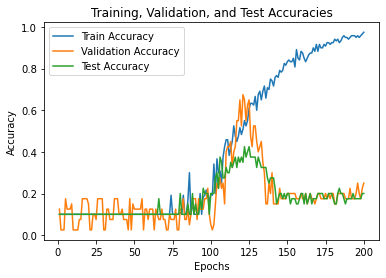

In [529]:
# Plotting the accuracies
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')

plt.title('Training, Validation, and Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(train_graph, train_graph.ndata['feat'])
    loss = criterion(logits, train_graph.ndata['label'])
    loss.backward()
    optimizer.step()

    # Evaluation on the training set
    model.eval()
    with torch.no_grad():
        train_logits = model(train_graph, train_graph.ndata['feat'])
        train_predictions = torch.argmax(train_logits, dim=1)
        train_true_labels = train_graph.ndata['label']
        train_accuracy = torch.sum(train_predictions == train_graph.ndata['label']).item() / len(train_graph.ndata['label'])

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        val_logits = model(val_graph, val_graph.ndata['feat'])
        val_predictions = torch.argmax(val_logits, dim=1)
        val_true_labels = val_graph.ndata['label']
        val_accuracy = torch.sum(val_predictions == val_graph.ndata['label']).item() / len(val_graph.ndata['label'])

    # Evaluation on the testing set
    model.eval()
    with torch.no_grad():
        test_logits = model(test_graph, test_graph.ndata['feat'])
        test_predictions = torch.argmax(test_logits, dim=1)
        test_true_labels = test_graph.ndata['label']
        test_accuracy = torch.sum(test_predictions == test_graph.ndata['label']).item() / len(test_graph.ndata['label'])

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [530]:
train_predictions

tensor([1, 1, 8, 2, 8, 2, 4, 6, 5, 1, 3, 1, 0, 0, 8, 1, 7, 6, 8, 0, 4, 7, 7, 1,
        2, 0, 4, 3, 8, 9, 8, 1, 9, 9, 5, 0, 0, 3, 5, 7, 6, 5, 6, 3, 6, 2, 6, 9,
        5, 6, 2, 4, 5, 8, 2, 9, 5, 3, 0, 4, 6, 3, 4, 9, 8, 1, 4, 1, 9, 4, 3, 9,
        9, 6, 5, 3, 8, 5, 6, 0, 0, 6, 7, 4, 2, 7, 0, 5, 7, 6, 7, 0, 2, 2, 2, 9,
        8, 9, 2, 5, 7, 9, 8, 2, 1, 4, 5, 8, 0, 4, 7, 1, 5, 7, 3, 1, 6, 9, 7, 3])

In [531]:
train_true_labels

tensor([1, 1, 8, 2, 8, 2, 4, 6, 5, 1, 3, 1, 0, 0, 8, 1, 7, 6, 8, 0, 4, 7, 7, 1,
        2, 0, 4, 3, 8, 9, 8, 1, 9, 9, 5, 0, 0, 3, 5, 7, 6, 3, 6, 3, 6, 2, 6, 9,
        5, 6, 2, 4, 5, 8, 2, 9, 5, 3, 0, 4, 4, 3, 4, 9, 8, 1, 4, 1, 9, 4, 3, 9,
        9, 6, 5, 3, 8, 5, 6, 0, 0, 6, 7, 4, 2, 7, 0, 5, 7, 6, 7, 0, 2, 2, 2, 9,
        8, 3, 2, 5, 7, 9, 8, 2, 1, 4, 5, 8, 0, 4, 7, 1, 5, 7, 3, 1, 6, 9, 7, 3])

In [532]:
test_predictions

tensor([4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4,
        5, 4, 4, 4, 2, 5, 4, 4, 4, 8, 4, 9, 5, 4, 4, 4])

In [533]:
test_true_labels

tensor([6, 2, 3, 1, 6, 0, 8, 2, 9, 1, 7, 7, 9, 4, 7, 4, 0, 9, 8, 3, 0, 4, 9, 6,
        5, 7, 8, 1, 1, 5, 5, 2, 2, 0, 3, 3, 5, 8, 6, 4])

# Assign features and labels to the graph
g.ndata['feat'] = X_tensor
g.ndata['label'] = y_tensor

num_heads = 8
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GATClassifier(in_features=job_desc_features.shape[1], num_classes=len(label_encoder.classes_), num_heads=num_heads, dropout=dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 100

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(g, g.ndata['feat'])
    loss = criterion(logits, g.ndata['label'])
    loss.backward()
    optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(g, g.ndata['feat'])
        predictions = torch.argmax(logits, dim=1)
        true_labels = g.ndata['label']
        accuracy = torch.sum(predictions == true_labels).item() / len(true_labels)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")


In [44]:
predictions

NameError: name 'predictions' is not defined

In [ ]:
true_labels